# Wereldwijde ontbossing

De datasets van [Global Forest Watch](https://www.globalforestwatch.org/dashboards/global/?location=WyJnbG9iYWwiXQ%3D%3D) (GFW) bevatten informatie over de staat van bossen over de hele wereld:

1. Het verlies van **primaire bossen** per locatie van 2001 - 2023.
2. De oorzaken van de afnemende **boomdichtheid** van 2001 - 2023 (bosbranden, urbanisatie, landbouw, bosbouw of ontbossing).
3. Boomdichtheid die verloren is gegaan door **bosbranden** van 2001 - 2023.

In [2]:
import pandas as pd

# Afkortingen voor namen van landen
iso = pd.read_csv("data/iso_metadata.csv")

# Data inladen
primary_forests_tropics = pd.read_csv("data/primary_forests/treecover_loss_in_primary_forests_2001_tropics_only__ha.csv")
primary_forests = pd.read_csv("data/primary_forests/treecover_loss__ha.csv")
primary_forests_extent = pd.read_csv("data/primary_forests/treecover_extent_2000_in_primary_forests_2001_tropics_only__ha.csv")

treecover = pd.read_csv("data/treecover/treecover_loss__ha.csv")
treecover_extent = pd.read_csv("data/treecover/treecover_extent_2000__ha.csv")

fires = pd.read_csv("data/fires/treecover_loss_from_fires_by_region__ha.csv")


### Opschonen

In plaats van de landnamen hebben sommige databestanden hier afkortingen voor. Deze gaan we linken aan de landnamen.

In [3]:
# Merge data based on the country names and iso
primary_forests_tropics = primary_forests_tropics.merge(iso[["iso", "name"]], on="iso", how="left")
primary_forests = primary_forests.merge(iso[["iso", "name"]], on="iso", how="left")
primary_forests_extent = primary_forests_extent.merge(iso[["iso", "name"]], on="iso", how="left")

treecover_extent = treecover_extent.merge(iso[["iso", "name"]], on="iso", how="left")

fires = fires.merge(iso[["iso", "name"]], on="iso", how="left")

## 1. Primaire bossen

Plot het totale verlies van primaire bossen (alleen tropische regenwouden) over de jaren heen, en hoe dit overeenkomt met de CO2 uitstoot.

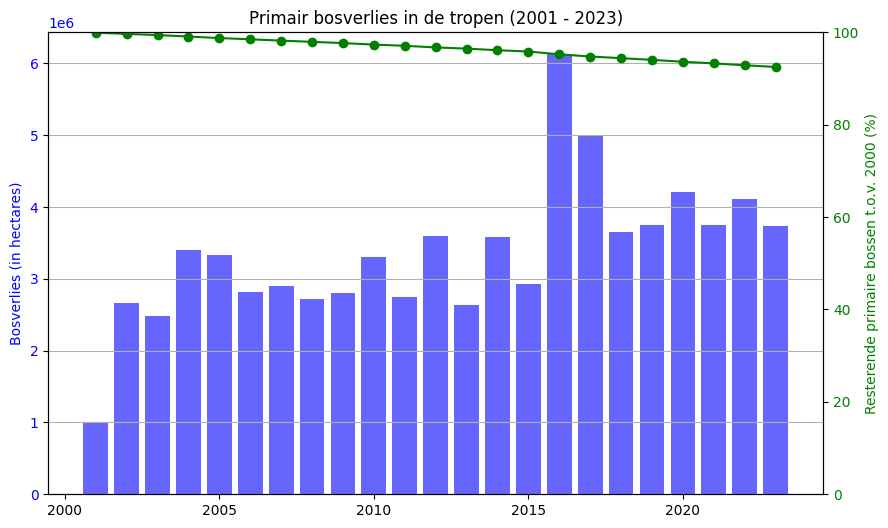

In [4]:
import matplotlib.pyplot as plt

# Group by year and sum the primary forest loss in the tropics
forest_loss_tropics = primary_forests_tropics.groupby('umd_tree_cover_loss__year')['umd_tree_cover_loss__ha'].sum()

# Calculate the cumulative primary forest loss in the tropics
cumulative_forest_loss_tropics = forest_loss_tropics.cumsum()

# Calculate the worldwide primary forest area for the year 2000
primary_forests_extent_2000 = primary_forests_extent['umd_tree_cover_extent_2000__ha'].sum()

# Calculate the percentage of remaining primary forest worldwide for each year
remaining_primary_forest_percentage = (primary_forests_extent_2000 - cumulative_forest_loss_tropics) / primary_forests_extent_2000 * 100

# Merge the two series into one DataFrame
merged_primary_forests = pd.DataFrame({
    'forest_loss': forest_loss_tropics,
    'remaining_forest_percentage': remaining_primary_forest_percentage
})

# Create a bar chart for primary forest loss in the tropics
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(merged_primary_forests.index, merged_primary_forests['forest_loss'], color='b', alpha=0.6, label='Bosverlies (in hectares)')
ax1.set_xlabel('')
ax1.set_ylabel('Bosverlies (in hectares)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the percentage of remaining primary forest
ax2 = ax1.twinx()
ax2.plot(merged_primary_forests.index, merged_primary_forests['remaining_forest_percentage'], color='g', marker='o', label='Resterende Boomdichtheid (%)')
ax2.set_ylabel('Resterende primaire bossen t.o.v. 2000 (%)', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_ylim(0, 100)

plt.title('Primair bosverlies in de tropen (2001 - 2023)')
ax1.grid(axis='y')  # Grid only on the y-axis for the bar chart

plt.show()


Welke landen zagen de grootste krimp in boomdichtheid?

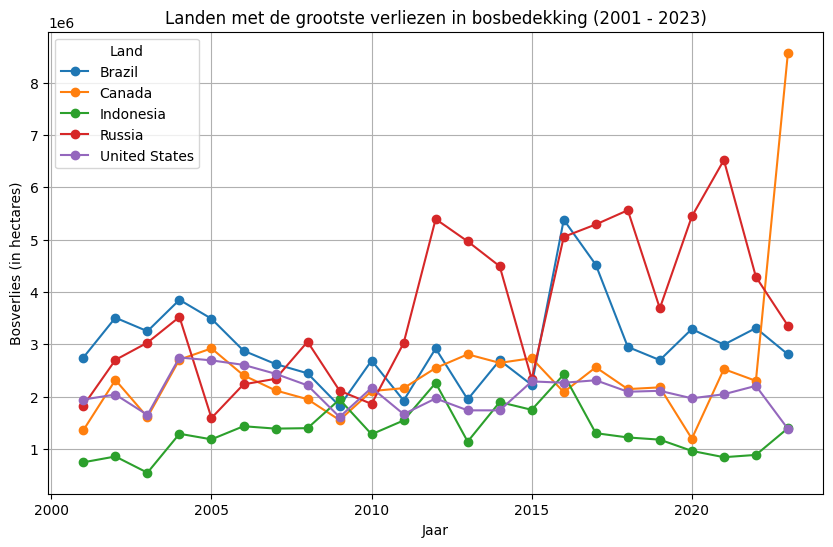

In [13]:
# Group by country and sum the forest loss
country_forest_loss = primary_forests.groupby('name')['umd_tree_cover_loss__ha'].sum()

# Get the top 5 countries with the most forest loss
top_5_countries = country_forest_loss.nlargest(5).index

# Filter the dataset for the top 5 countries
top_5_treecover_loss = primary_forests[primary_forests['name'].isin(top_5_countries)]

# Pivot the data to get years as the index and countries as columns
pivot_data = top_5_treecover_loss.pivot(index='umd_tree_cover_loss__year', columns='name', values='umd_tree_cover_loss__ha')

# Plot the data for the top 5 countries
pivot_data.plot(figsize=(10, 6), marker='o')

# Add title and labels
plt.title('Landen met de grootste verliezen in bosbedekking (2001 - 2023)')
plt.xlabel('Jaar')
plt.ylabel('Bosverlies (in hectares)')
plt.legend(title='Land')
plt.grid(True)
plt.show()


## 2. Boomdichtheid

Wat zijn de oorzaken voor de krimpende boomdichtheid door de jaren heen?

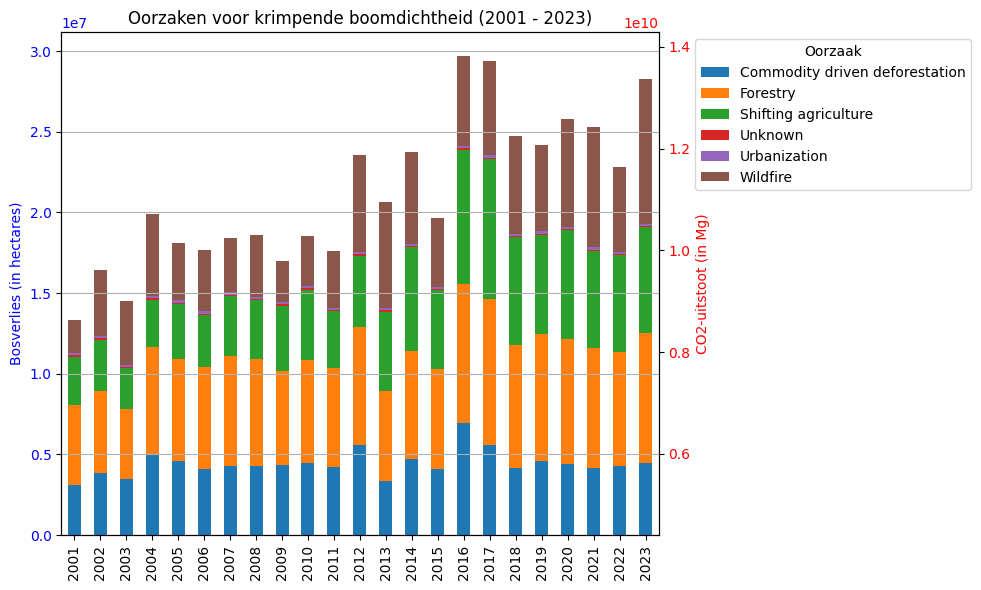

In [6]:
# Group by driver and year to sum the treecover loss
driver_loss_by_year = treecover.groupby(['tsc_tree_cover_loss_drivers__driver', 'umd_tree_cover_loss__year'])['umd_tree_cover_loss__ha'].sum().unstack()

# Group by year and sum the CO2 emissions
co2_emissions_by_year = treecover.groupby('umd_tree_cover_loss__year')['gfw_gross_emissions_co2e_all_gases__Mg'].sum()

# Create a bar chart for the treecover loss by driver
fig, ax1 = plt.subplots(figsize=(10, 6))

driver_loss_by_year.T.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Bosverlies (in hectares)', color='b')
ax1.set_title('Oorzaken voor krimpende boomdichtheid (2001 - 2023)')
ax1.legend(title='Oorzaak', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(axis='y')

# Create a second y-axis for the CO2 emissions
ax2 = ax1.twinx()
ax2.plot(co2_emissions_by_year.index, co2_emissions_by_year.values, color='r', marker='o', label='CO2-uitstoot (in Mg)')
ax2.set_ylabel('CO2-uitstoot (in Mg)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.tight_layout()
plt.show()

Welke oorzaak draagt het meest bij aan het verlies van boomdichtheid over de gehele periode?

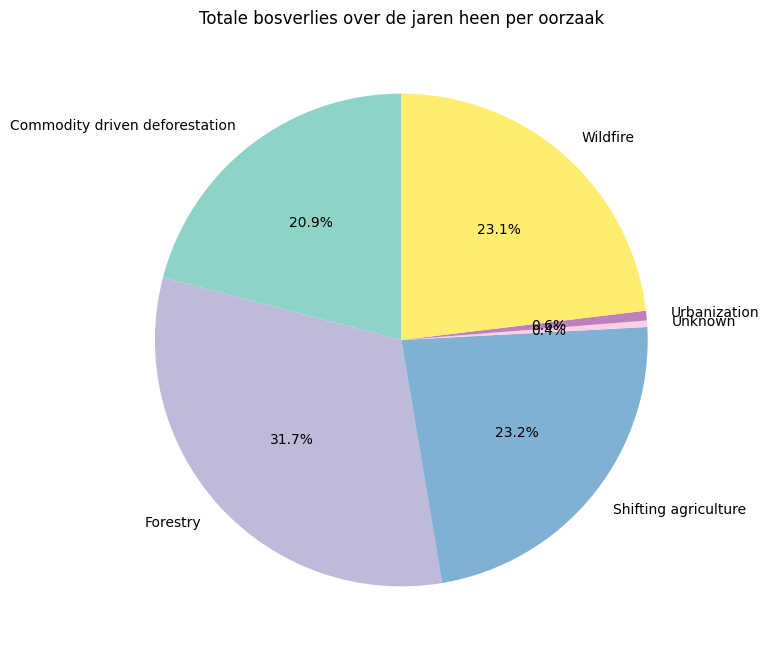

In [7]:
# Group by driver to get the total treecover loss
total_loss_by_driver = treecover.groupby('tsc_tree_cover_loss_drivers__driver')['umd_tree_cover_loss__ha'].sum()

# Plot the pie chart
plt.figure(figsize=(8, 8))
total_loss_by_driver.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Set3')
plt.title('Totale bosverlies over de jaren heen per oorzaak')
plt.ylabel('')  # Hide the y-label
plt.show()


Hoeveel hectare boomdichtheid is er nog over ten opzichte van 2000?

In [8]:
# Calculate the worldwide treecover for the year 2000
total_treecover_extent_2000 = treecover_extent['umd_tree_cover_extent_2000__ha'].sum()

# Calculate the worldwide total treecover loss over the years
total_forest_loss = primary_forests['umd_tree_cover_loss__ha'].sum()

remaining_treecover = total_treecover_extent_2000 - total_forest_loss

print(f"Wereldwijde boomdichtheid in het jaar 2000: {total_treecover_extent_2000} hectares")
print(f"Overgebleven boomdichtheid in het jaar 2023: {remaining_treecover} hectares")

Wereldwijde boomdichtheid in het jaar 2000: 3993353866.2128496 hectares
Overgebleven boomdichtheid in het jaar 2023: 3505630181.5410523 hectares


## 3. Bosbranden

Hoeveel bosverlies vindt er plaats als gevolg van bosbranden?

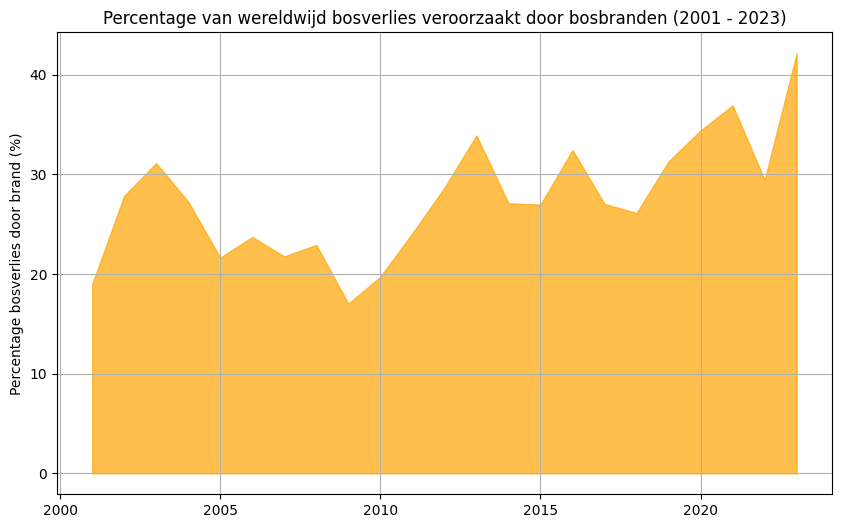

In [9]:
# Group by year and sum the tree cover loss and loss from fires
total_loss_by_year = fires.groupby('umd_tree_cover_loss__year')['umd_tree_cover_loss__ha'].sum()
fire_loss_by_year = fires.groupby('umd_tree_cover_loss__year')['umd_tree_cover_loss_from_fires__ha'].sum()

# Calculate the percentage of loss due to fires
percentage_fire_loss = (fire_loss_by_year / total_loss_by_year) * 100

# Plot the percentage of tree cover loss due to fires
plt.figure(figsize=(10, 6))
plt.fill_between(percentage_fire_loss.index, percentage_fire_loss.values, color='orange', alpha=0.7)
plt.title('Percentage van wereldwijd bosverlies veroorzaakt door bosbranden (2001 - 2023)')
plt.xlabel('')
plt.ylabel('Percentage bosverlies door brand (%)')
plt.grid(True)
plt.show()

Welke landen worden het meest geteisterd door bosbranden?

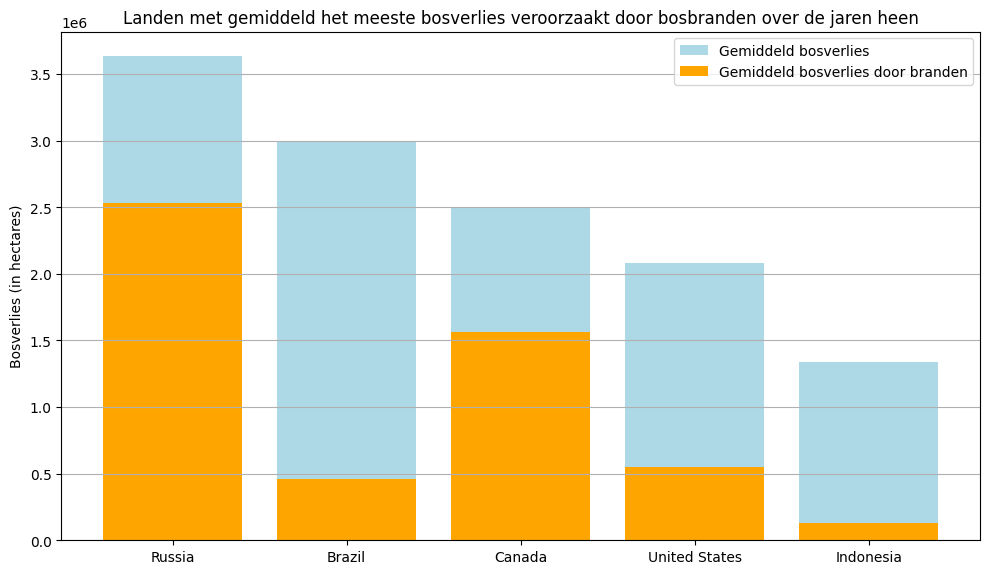

In [10]:
# Create a new column that calculates the percentage of tree cover loss caused by fires
fires['fire_loss_percentage'] = (fires['umd_tree_cover_loss_from_fires__ha'] / fires['umd_tree_cover_loss__ha']) * 100

# Group by country and calculate the average tree cover loss and the loss from fires
avg_loss_by_country = fires.groupby('name')['umd_tree_cover_loss__ha'].mean()
avg_fire_loss_by_country = fires.groupby('name')['umd_tree_cover_loss_from_fires__ha'].mean()

# Merge the two series into one DataFrame
merged_forest_loss = pd.DataFrame({
    'avg_loss': avg_loss_by_country,
    'avg_fire_loss': avg_fire_loss_by_country
})

# Get the top 5 countries with the most tree cover loss
top_5_countries = merged_forest_loss.nlargest(5, 'avg_loss').index

# Filter the data for the top 5 countries
top_5_fires = merged_forest_loss.loc[top_5_countries]

# Plot the total tree cover loss and the loss from fires
plt.figure(figsize=(10, 6))
plt.bar(top_5_fires.index, top_5_fires['avg_loss'], label='Gemiddeld bosverlies', color='lightblue')
plt.bar(top_5_fires.index, top_5_fires['avg_fire_loss'], label='Gemiddeld bosverlies door branden', color='orange')

# Add labels and title
plt.title('Landen met gemiddeld het meeste bosverlies veroorzaakt door bosbranden over de jaren heen')
plt.xlabel('')
plt.ylabel('Bosverlies (in hectares)')
plt.legend()
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()


### Exports

Exporteer de opgeschoonde benodige data voor de grafieken.

In [15]:
# Graph 1
merged_primary_forests.to_csv("data/clean/primary_forest_loss.csv")

# Graph 2
pivot_data.to_csv("data/clean/treecover_loss_countries.csv")

# Graph 5
driver_loss_by_year.to_csv("data/clean/treecover_loss_drivers.csv")

# Graph 6
top_5_fires.to_csv("data/clean/fire_treecover_loss_countries.csv")